<a href="https://colab.research.google.com/github/Mainak1792/fellowship_of_the_ring/blob/main/fellowship_flower_resnet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Use a pretrained ResNet 18 and train on the Flowers dataset. Use cut-out and discriminative learning rates. Measure its effect on your model's performance.

Import the Fast Ai library files

In [1]:
from fastai import *
from fastai.basics import *
from fastai.vision import *
from fastai.metrics import *

In [2]:
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

Download_the_dataset

In [3]:
path=untar_data(URLs.FLOWERS)

In [4]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-102-flowers/test.txt'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/valid.txt'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/train.txt'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/jpg')]

In [5]:
path_img=path/'jpg'

Read the directory

In [6]:
trn=pd.read_csv(path/'train.txt',sep=" ",header=None)
val=pd.read_csv(path/'valid.txt',sep=" ",header=None)
tst=pd.read_csv(path/'test.txt',sep=" ",header=None)
df = trn.append(val,ignore_index=True).append(tst,ignore_index=True)
df.columns=['Img','Class']
df.index=df.Img
df.head()

,Img,Class
Img,,
jpg/image_03860.jpg,jpg/image_03860.jpg,16
jpg/image_06092.jpg,jpg/image_06092.jpg,13
jpg/image_02400.jpg,jpg/image_02400.jpg,42
jpg/image_02852.jpg,jpg/image_02852.jpg,55
jpg/image_07710.jpg,jpg/image_07710.jpg,96


In [7]:
len(trn), len(val), len(tst)

(1020, 1020, 6149)

Extract Categories


In [8]:
from bs4 import BeautifulSoup
import re

In [9]:
url = 'http://www.robots.ox.ac.uk/~vgg/data/flowers/102/categories.html'
r= requests.get(url)

soup=BeautifulSoup(r.content, "lxml")
ims=soup.findAll('img')
print(ims)

[<img alt="alpine sea holly" border="0" height="75" src="thumbs/thumbim_06974.jpg" width="78"/>, <img alt="buttercup" border="0" height="76" src="thumbs/thumbim_04657.jpg" width="75"/>, <img alt="fire lily" border="0" height="75" src="thumbs/thumbim_06779.jpg" width="75"/>, <img alt="anthurium" border="0" height="75" src="thumbs/thumbim_02011.jpg" width="76"/>, <img alt="californian poppy" border="0" height="75" src="thumbs/thumbim_03206.jpg" width="76"/>, <img alt="foxglove" border="0" height="75" src="thumbs/thumbim_07419.jpg" width="80"/>, <img alt="artichoke" border="0" height="75" src="thumbs/thumbim_04093.jpg" width="80"/>, <img alt="camellia" border="0" height="75" src="thumbs/thumbim_07652.jpg" width="75"/>, <img alt="frangipani" border="0" height="76" src="thumbs/thumbim_00784.jpg" width="75"/>, <img alt="azalea" border="0" height="75" src="thumbs/thumbim_03581.jpg" width="75"/>, <img alt="canna lily" border="0" height="75" src="thumbs/thumbim_04479.jpg" width="75"/>, <img alt

Output sample labels 


In [10]:
sample = {}
for im in ims[0:]:
    sample[f"jpg/image_{im['src'].split('_')[-1]}"] = im['alt']
len(sample.keys()), {k: sample[k] for k in list(sample)[:5]}

(102,
 {'jpg/image_02011.jpg': 'anthurium',
  'jpg/image_03206.jpg': 'californian poppy',
  'jpg/image_04657.jpg': 'buttercup',
  'jpg/image_06779.jpg': 'fire lily',
  'jpg/image_06974.jpg': 'alpine sea holly'})

In [11]:
names = {}
for im in sample.keys():
  names[df.loc[im]['Class']]=sample[im]

{k: names[k] for k in list(names)[:5]}

{20: 'fire lily',
 34: 'alpine sea holly',
 47: 'buttercup',
 64: 'californian poppy',
 79: 'anthurium'}

In [12]:
codes = np.array([names[i] for i in range(len(names))]); codes

array(['pink primrose', 'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea', ..., 'bromelia',
       'blanket flower', 'trumpet creeper', 'blackberry lily'], dtype='<U25')

Replace space with _

In [13]:
trn[trn.columns[-1]] = trn[trn.columns[-1]].apply(lambda x: codes[x].replace(' ','_'))
val[val.columns[-1]] = val[val.columns[-1]].apply(lambda x: codes[x].replace(' ','_'))
tst[tst.columns[-1]] = tst[tst.columns[-1]].apply(lambda x: codes[x].replace(' ','_'))

visualise a image

In [14]:
fnames= get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/oxford-102-flowers/jpg/image_04996.jpg'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/jpg/image_01923.jpg'),
 PosixPath('/root/.fastai/data/oxford-102-flowers/jpg/image_05362.jpg')]

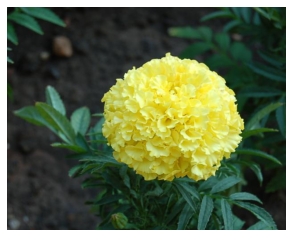

In [15]:
img_f = fnames[0]
img=open_image(img_f)
img.show(figsize=(5,5))

Training the model with pretrained Resnet 18

In [16]:
src_size = min(img.size)

In [17]:
size=src_size//2
bs=4

In [18]:
trnList = ImageList.from_df(df=trn, path=path)
valList = ImageList.from_df(df=val, path=path)
tstList = ImageList.from_df(df=tst, path=path)

In [19]:
src = (ImageList.from_folder(path).split_by_list(trnList,valList).label_from_df())

In [20]:
data = (src.transform(get_transforms(),size=size).databunch(bs=bs).normalize(imagenet_stats))

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


In [21]:
metrics=accuracy

In [22]:
learn=cnn_learner(data,models.resnet18,metrics=metrics)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy,time


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


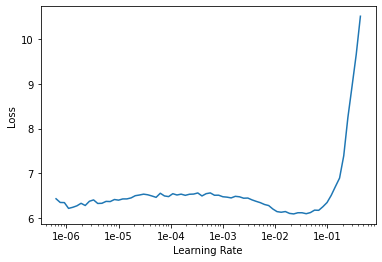

In [23]:
lr_find(learn)
learn.recorder.plot()

In [24]:
lr=3e-3

In [27]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,accuracy,time
0,5.988777,4.609014,0.047059,00:37
1,4.839447,3.359592,0.233333,00:35
2,3.601730,2.082528,0.519608,00:35
3,2.866500,1.554274,0.605882,00:34
4,2.455348,1.215590,0.680392,00:34
5,2.258018,1.138643,0.722549,00:34
6,1.862020,1.249255,0.663725,00:34
7,1.978153,1.144212,0.692157,00:35
8,1.861943,0.969249,0.738235,00:34
9,1.738274,0.895451,0.767647,00:35


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

In [28]:
learn.save('stage-1')

Training 1 is complete. Lets visualise the saved weights


In [29]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (1020 items)
x: ImageList
Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
y: CategoryList
purple_coneflower,spear_thistle,sword_lily,bishop_of_llandaff,mallow
Path: /root/.fastai/data/oxford-102-flowers;

Valid: LabelList (1020 items)
x: ImageList
Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250),Image (3, 250, 250)
y: CategoryList
canna_lily,bolero_deep_blue,english_marigold,alpine_sea_holly,anthurium
Path: /root/.fastai/data/oxford-102-flowers;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_

Accuracy of training is low. Hence increasing epochs to get high accuracy

In [31]:
learn.unfreeze()

In [32]:
lrs= slice(lr/400,lr/4)

In [33]:
learn.fit_one_cycle(15,lrs,pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,1.559225,0.860627,0.769608,00:44
1,1.305945,0.845643,0.770588,00:37
2,1.131741,0.776028,0.799020,00:38
3,1.132711,0.723991,0.804902,00:36
4,1.060423,0.652905,0.816667,00:41
5,0.955230,0.684048,0.810784,00:37
6,0.892195,0.635241,0.827451,00:36
7,1.114308,0.597547,0.831373,00:37
8,0.923450,0.552709,0.846078,00:37
9,1.006423,0.576942,0.837255,00:38


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

In [34]:
learn.save('stage-2')

Accuracy increased to 88%. To increase more lets change the learning rate and also increase the epoch

In [35]:
learn.unfreeze()

In [36]:
lrs=slice(1e-5,lr/10)

In [39]:
learn.fit_one_cycle(15,lrs,pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,0.387259,0.408861,0.879412,00:40
1,0.358627,0.374497,0.892157,00:36
2,0.391389,0.359686,0.899020,00:35
3,0.369560,0.391697,0.893137,00:35
4,0.480687,0.352204,0.897059,00:36
5,0.342796,0.367485,0.902941,00:36
6,0.315683,0.369686,0.893137,00:37
7,0.375298,0.351882,0.899020,00:41
8,0.381943,0.414271,0.889216,00:41
9,0.308669,0.407482,0.891176,00:41


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3680: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

Accuracy achieved 91%